In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import random
import seaborn as sns
import pandas as pd
import pickle
import math
import torchaudio

from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
from torchinfo import summary
from torchsummary import summary
from torchvision.ops import SqueezeExcitation
from tqdm import tqdm
from torchvision import datasets, transforms
from collections import defaultdict
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from functools import reduce
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

pd.set_option('future.no_silent_downcasting', True)

### Loading data

In [2]:
keys_s = '0123456789abcdefghijklmnopqrstuvwxyz'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}

In [3]:
def isolator(signal, sample_rate, size, scan, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=size, hop_length=scan)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*scan) + size//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            strokes.append(torch.tensor(keystroke)[None, :])
            if show:
                plt.figure(figsize=(7, 2))
                librosa.display.waveshow(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

def convert_to_df(AUDIO_FILE):
    for i, File in enumerate(keys):
        loc = AUDIO_FILE + File
        samples, sample_rate = librosa.load(loc, sr=None)
        #samples = samples[round(1*sample_rate):]
        strokes = []
        prom = 0.06
        step = 0.005
        while not len(strokes) == 25:
            strokes = isolator(samples[1*sample_rate:], sample_rate, 48, 24, 2400, 12000, prom, False)
            if len(strokes) < 25:
                prom -= step
            if len(strokes) > 25:
                prom += step
            if prom <= 0:
                print('-- not possible for: ',File)
                break
            step = step*0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace=True)
    return df, sample_rate 

In [4]:
data_frame, sr = convert_to_df("../dataset/Zoom/")

print(data_frame.head())
print(data_frame.info())

  Key                                               File
0   0  [[tensor(-6.1035e-05), tensor(-6.1035e-05), te...
1   0  [[tensor(0.), tensor(-3.0518e-05), tensor(-3.0...
2   0  [[tensor(3.0518e-05), tensor(3.0518e-05), tens...
3   0  [[tensor(-0.0002), tensor(-0.0002), tensor(-0....
4   0  [[tensor(6.1035e-05), tensor(6.1035e-05), tens...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Key     900 non-null    object
 1   File    900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB
None


In [5]:
train_set, tmp_set = train_test_split(data_frame, test_size=0.3)
val_set, test_set = train_test_split(tmp_set, test_size=0.33)

print("Sample rate:", sr)
print(len(train_set), len(val_set), len(test_set))

Sample rate: 32000
630 180 90


### Data augmentation setup

In [6]:
class MyDataset(Dataset):
    def __init__(self, file_name, transform = None, aug = None):
        df = file_name
        self.transform = transform
        self.aug = aug
        self.labels = df['Key']
        self.values = df['File']
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        label = self.labels.iloc[index]
        value = self.values.iloc[index]
        waveform = self.values.iloc[index]
        label = self.labels.iloc[index]
        if self.transform:
            waveform = waveform.numpy()
            waveform = waveform.flatten()
            waveform = self.transform(waveform)
        if self.aug:
            waveform = self.aug(waveform)
        return waveform, label

class ToMelSpectrogram:
    def __call__(self, samples):
#         samples = np.array(samples)
        spec = librosa.feature.melspectrogram(y = samples, sr = sr, n_mels=64, n_fft=2048, win_length=1024, hop_length=226)
        return librosa.power_to_db(spec)

class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4)
        random_shift =random.randint(0, shift)
        data_roll = np.roll(samples, random_shift)
        return data_roll
    
class SpecAugment():
    def __call__(self, samples):
        num_mask = 2
        freq_masking_max_percentage=0.10
        time_masking_max_percentage=0.10
        spec = samples.copy()
        mean_value = spec.mean()
        for i in range(num_mask):
            all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
            freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[:, f0:f0 + num_freqs_to_mask] = mean_value

            time_percentage = random.uniform(0.0, time_masking_max_percentage)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[t0:t0 + num_frames_to_mask, :] = mean_value
        return spec

aug = Compose([
    TimeShifting(),
    ToMelSpectrogram(),
    SpecAugment(),
    ToTensor()
    ])

transform = Compose([
    ToMelSpectrogram(),
    ToTensor()])
        
train_set = MyDataset(train_set, aug = aug)
val_set = MyDataset(val_set, transform = transform)
test_set = MyDataset(test_set, transform = transform)

### Training set image (augmented vs non-augmented)

torch.Size([64, 64])


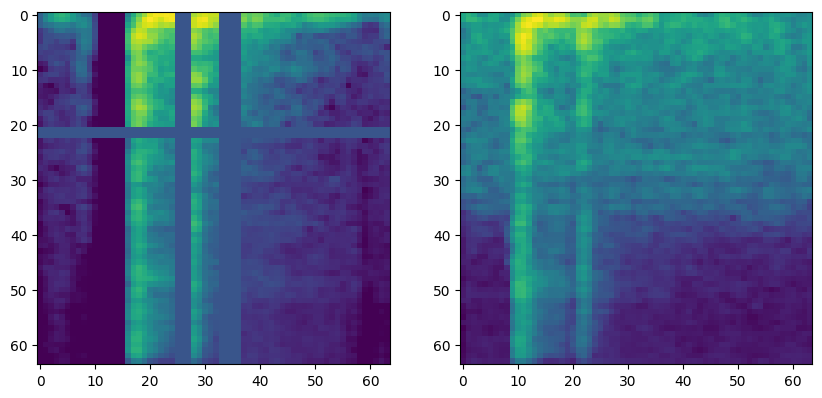

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(train_set[0][0][0], cmap='viridis')
ax2.imshow(val_set[0][0][0], cmap='viridis')
print(train_set[0][0][0].shape)
ax1.grid(False)
ax2.grid(False)
plt.show()

In [8]:
print("number of classes:", len(np.unique(data_frame['Key'])))

number of classes: 36


### CoAtNet (Model)

In [9]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [10]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [11]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [12]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [13]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [14]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [15]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [16]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [17]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [18]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=36):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [19]:
# CoAtNet-1
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D

model = MyCoAtNet(nums_blocks, channels)

c:\Users\user\miniconda3\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.apply(init_linear)
model.to(device)

print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

summary(model, input_size=(1, 64, 64))

Number of parameters: 24,033,296
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

### Training

In [22]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    shuffle=True
)

In [23]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [24]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.AdamW(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [25]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [26]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

Epoch [1/1100], Loss: 13.426941871643066, Accuracy: 0.031746031746031744 Correct: 20 Total: 630 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.06111111111111111 Validation loss: 20.804431915283203 Correct: 11 Total: 180
Epoch [2/1100], Loss: 13.378430366516113, Accuracy: 0.06825396825396825 Correct: 43 Total: 630 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.06111111111111111 Validation loss: 16.60166358947754 Correct: 11 Total: 180
Epoch [3/1100], Loss: 8.68999195098877, Accuracy: 0.0746031746031746 Correct: 47 Total: 630 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.10555555555555556 Validation loss: 11.03617000579834 Correct: 19 Total: 180
Epoch [4/1100], Loss: 12.310957908630371, Accuracy: 0.06507936507936508 Correct: 41 Total: 630 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.06666666666666667 Validation loss: 9.085830688476562 Correct: 12 Total: 180
Epoch [5/1100], Loss: 7.87420654296875

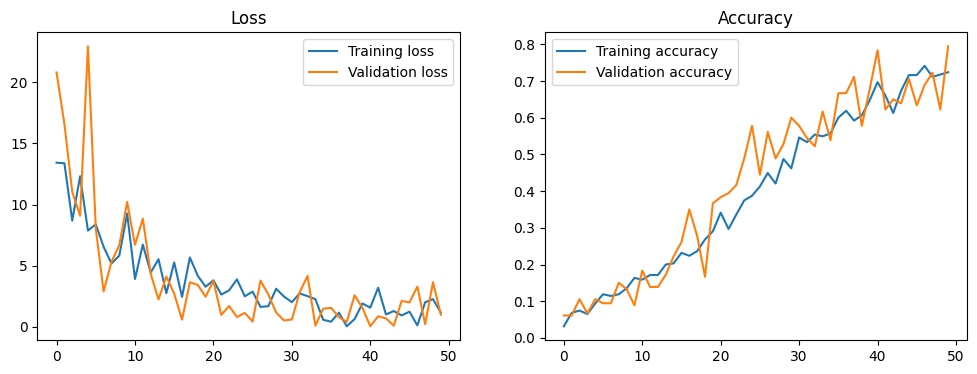

Epoch [51/1100], Loss: 1.227342128753662, Accuracy: 0.7793650793650794 Correct: 491 Total: 630 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.7611111111111111 Validation loss: 0.018054058775305748 Correct: 137 Total: 180
Epoch [52/1100], Loss: 0.5108165144920349, Accuracy: 0.7984126984126985 Correct: 503 Total: 630 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.7444444444444445 Validation loss: 2.5153348445892334 Correct: 134 Total: 180
Epoch [53/1100], Loss: 0.3908761441707611, Accuracy: 0.7682539682539683 Correct: 484 Total: 630 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.6888888888888889 Validation loss: 0.4527471363544464 Correct: 124 Total: 180
Epoch [54/1100], Loss: 1.1239348649978638, Accuracy: 0.7904761904761904 Correct: 498 Total: 630 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.7388888888888889 Validation loss: 0.9290683269500732 Correct: 133 Total: 180
Epoch [55

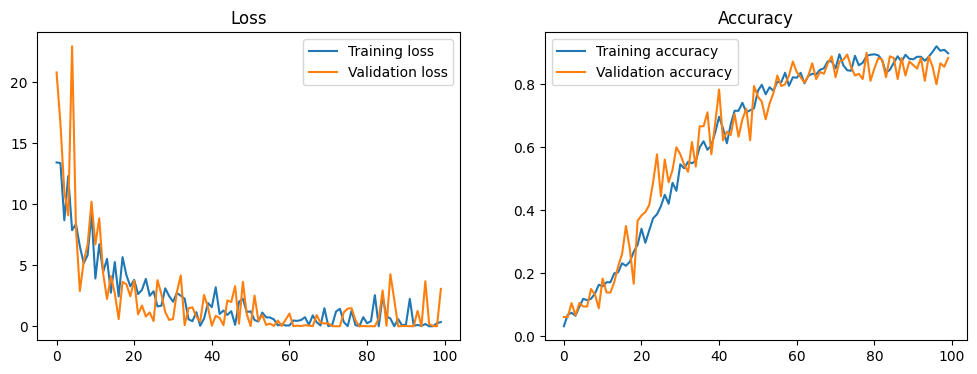

Epoch [101/1100], Loss: 0.02707274816930294, Accuracy: 0.9111111111111111 Correct: 574 Total: 630 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.8777777777777778 Validation loss: 0.05380886048078537 Correct: 158 Total: 180
Epoch [102/1100], Loss: 0.06970483064651489, Accuracy: 0.9238095238095239 Correct: 582 Total: 630 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.9222222222222223 Validation loss: 0.00012632993457373232 Correct: 166 Total: 180
Epoch [103/1100], Loss: 0.0260209571570158, Accuracy: 0.9301587301587302 Correct: 586 Total: 630 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.9055555555555556 Validation loss: 0.5127349495887756 Correct: 163 Total: 180
Epoch [104/1100], Loss: 1.9501768350601196, Accuracy: 0.9111111111111111 Correct: 574 Total: 630 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.85 Validation loss: 0.04865116626024246 Correct: 153 Total: 180
Epoch [105/

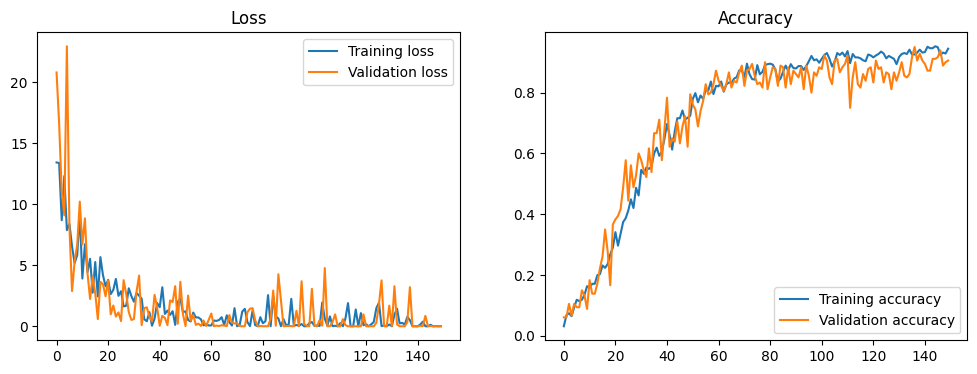

Epoch [151/1100], Loss: 1.0731350183486938, Accuracy: 0.9301587301587302 Correct: 586 Total: 630 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.8388888888888889 Validation loss: 0.0003074607811868191 Correct: 151 Total: 180
Epoch [152/1100], Loss: 0.016549652442336082, Accuracy: 0.9174603174603174 Correct: 578 Total: 630 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.8888888888888888 Validation loss: 1.549715989312972e-06 Correct: 160 Total: 180
Epoch [153/1100], Loss: 0.9480860829353333, Accuracy: 0.9174603174603174 Correct: 578 Total: 630 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.8777777777777778 Validation loss: 0.0012363370042294264 Correct: 158 Total: 180
Epoch [154/1100], Loss: 6.877474515931681e-05, Accuracy: 0.9317460317460318 Correct: 587 Total: 630 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.8944444444444445 Validation loss: 5.960463766996327e-08 Correct: 161 

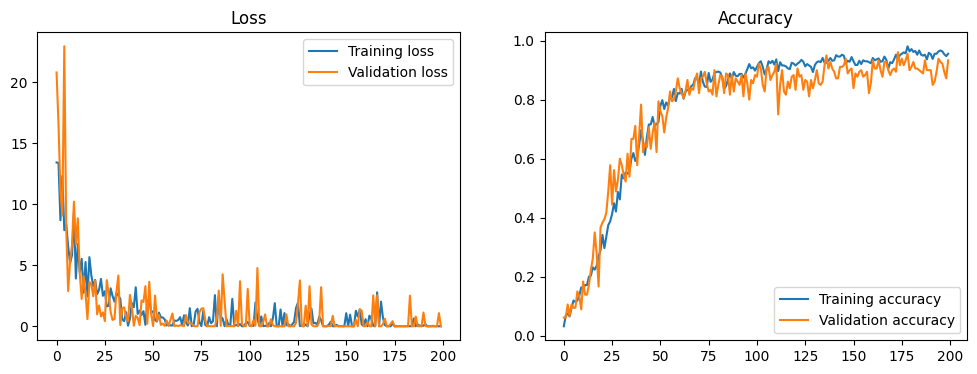

Epoch [201/1100], Loss: 0.43328049778938293, Accuracy: 0.9492063492063492 Correct: 598 Total: 630 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.9222222222222223 Validation loss: 0.08450917154550552 Correct: 166 Total: 180
Epoch [202/1100], Loss: 0.0007950672297738492, Accuracy: 0.9285714285714286 Correct: 585 Total: 630 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.9055555555555556 Validation loss: 0.9505508542060852 Correct: 163 Total: 180
Epoch [203/1100], Loss: 0.0027460912242531776, Accuracy: 0.9492063492063492 Correct: 598 Total: 630 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.9 Validation loss: 0.34660691022872925 Correct: 162 Total: 180
Epoch [204/1100], Loss: 0.7883424162864685, Accuracy: 0.9587301587301588 Correct: 604 Total: 630 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.9 Validation loss: 8.882538531906903e-05 Correct: 162 Total: 180
Epoch [205/1100], Loss

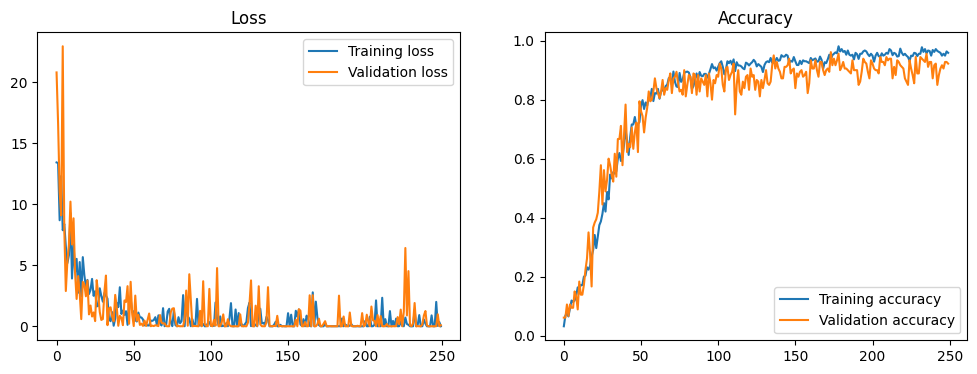

Epoch [251/1100], Loss: 0.9246930480003357, Accuracy: 0.9523809523809523 Correct: 600 Total: 630 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.8833333333333333 Validation loss: 0.031308744102716446 Correct: 159 Total: 180
Epoch [252/1100], Loss: 0.022040804848074913, Accuracy: 0.9523809523809523 Correct: 600 Total: 630 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.9111111111111111 Validation loss: 0.0003678798384498805 Correct: 164 Total: 180
Epoch [253/1100], Loss: 0.00028647188446484506, Accuracy: 0.9666666666666667 Correct: 609 Total: 630 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.9 Validation loss: 0.21198278665542603 Correct: 162 Total: 180
Epoch [254/1100], Loss: 0.0, Accuracy: 0.9746031746031746 Correct: 614 Total: 630 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.9055555555555556 Validation loss: 0.0 Correct: 163 Total: 180
Epoch [255/1100], Loss: 0.33262273669

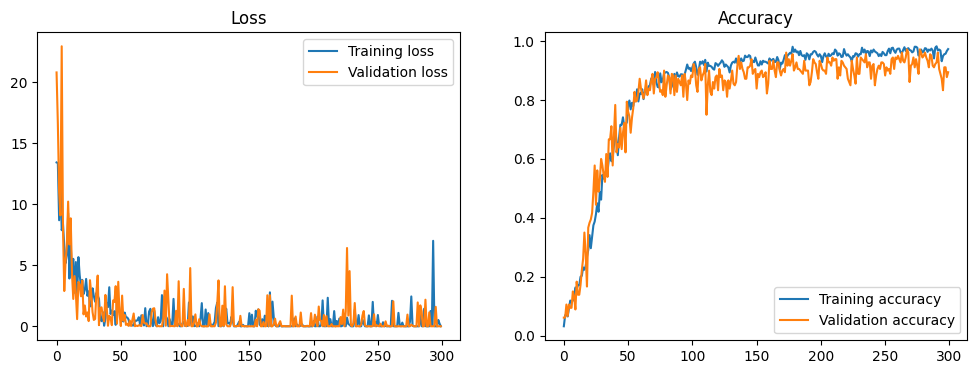

Epoch [301/1100], Loss: 0.0022217046935111284, Accuracy: 0.9634920634920635 Correct: 607 Total: 630 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.8944444444444445 Validation loss: 0.00010133767500519753 Correct: 161 Total: 180
Epoch [302/1100], Loss: 0.6596516966819763, Accuracy: 0.9698412698412698 Correct: 611 Total: 630 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.9055555555555556 Validation loss: 0.25109970569610596 Correct: 163 Total: 180
Epoch [303/1100], Loss: 2.08007240871666e-05, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.9166666666666666 Validation loss: 1.2954440116882324 Correct: 165 Total: 180
Epoch [304/1100], Loss: 2.7815488579108205e-07, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.9444444444444444 Validation loss: 0.000700083386618644 Correct: 170 T

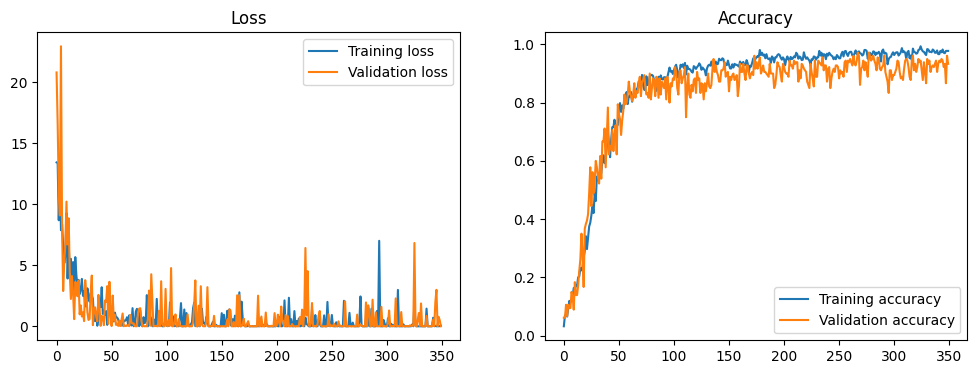

Epoch [351/1100], Loss: 5.960463411724959e-08, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.9444444444444444 Validation loss: 0.0 Correct: 170 Total: 180
Epoch [352/1100], Loss: 0.10023659467697144, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.9277777777777778 Validation loss: 0.00811040960252285 Correct: 167 Total: 180
Epoch [353/1100], Loss: 1.7086289517465048e-05, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.9388888888888889 Validation loss: 0.04079633578658104 Correct: 169 Total: 180
Epoch [354/1100], Loss: 2.8808801744162338e-06, Accuracy: 0.9873015873015873 Correct: 622 Total: 630 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.9611111111111111 Validation loss: 8.940680800151313e-07 Correct: 173 Total: 180
Epoch 

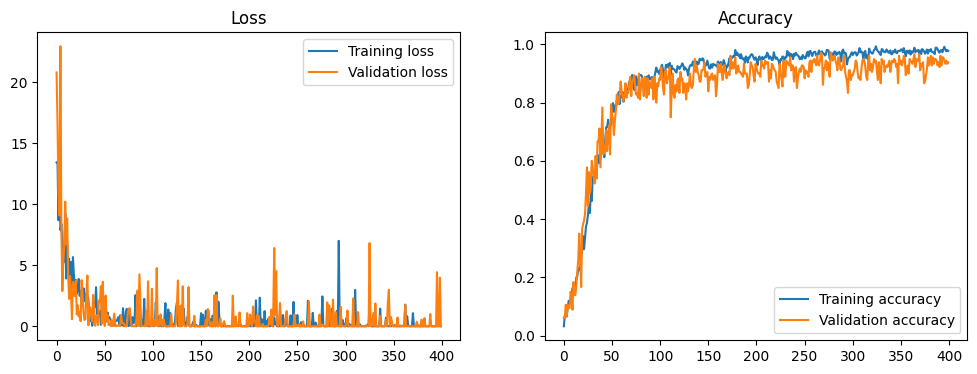

Epoch [401/1100], Loss: 0.6881077289581299, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.9722222222222222 Validation loss: 3.546451125657768e-06 Correct: 175 Total: 180
Epoch [402/1100], Loss: 0.0027688315603882074, Accuracy: 0.9714285714285714 Correct: 612 Total: 630 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.9 Validation loss: 2.3843741416931152 Correct: 162 Total: 180
Epoch [403/1100], Loss: 1.9868213740892315e-08, Accuracy: 0.953968253968254 Correct: 601 Total: 630 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.9444444444444444 Validation loss: 6.93999754730612e-05 Correct: 170 Total: 180
Epoch [404/1100], Loss: 9.635806236474309e-06, Accuracy: 0.9777777777777777 Correct: 616 Total: 630 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.9722222222222222 Validation loss: 1.5887254476547241 Correct: 175 Total: 180
Epoch 

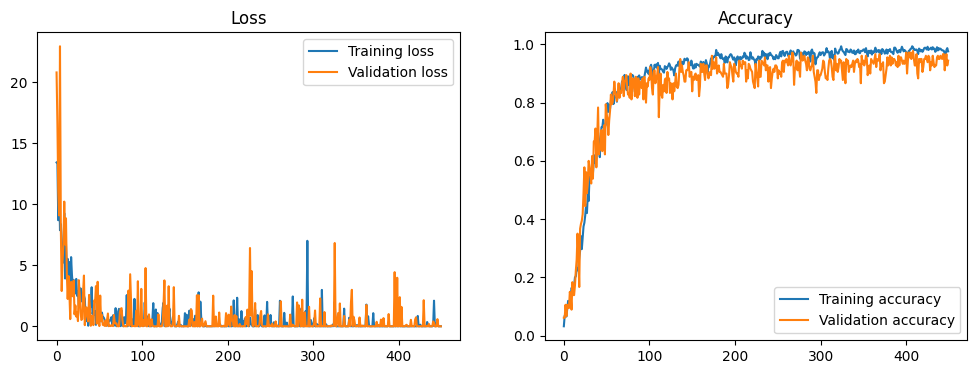

Epoch [451/1100], Loss: 0.00035942657268606126, Accuracy: 0.9841269841269841 Correct: 620 Total: 630 LR: 0.00029586363636363735 -> 0.000295410000000001
Validation Accuracy: 0.9222222222222223 Validation loss: 0.00019484040967654437 Correct: 166 Total: 180
Epoch [452/1100], Loss: 0.0, Accuracy: 0.9777777777777777 Correct: 616 Total: 630 LR: 0.000295410000000001 -> 0.00029495636363636464
Validation Accuracy: 0.9 Validation loss: 0.058089856058359146 Correct: 162 Total: 180
Epoch [453/1100], Loss: 0.01780228316783905, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 0.00029495636363636464 -> 0.0002945027272727283
Validation Accuracy: 0.9555555555555556 Validation loss: 0.37983477115631104 Correct: 172 Total: 180
Epoch [454/1100], Loss: 1.1920926112907182e-07, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 0.0002945027272727283 -> 0.00029404909090909194
Validation Accuracy: 0.9555555555555556 Validation loss: 1.4901158351676713e-07 Correct: 172 Total: 180
Epoch [455/1100]

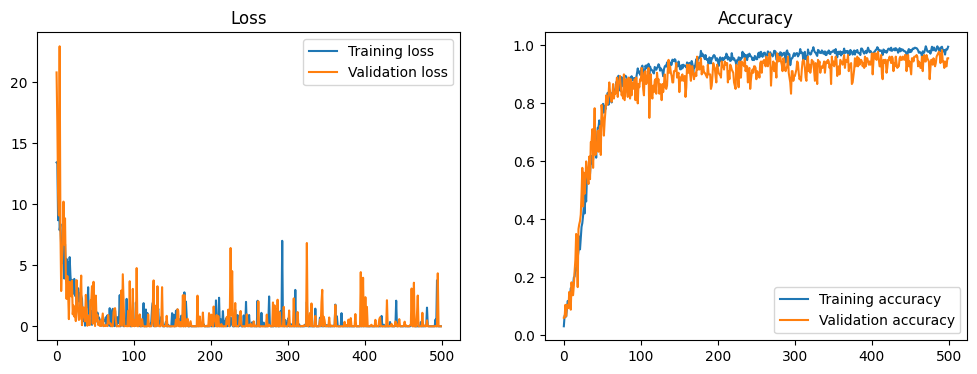

Epoch [501/1100], Loss: 1.9868213740892315e-08, Accuracy: 0.9857142857142858 Correct: 621 Total: 630 LR: 0.00027318181818181977 -> 0.0002727281818181834
Validation Accuracy: 0.95 Validation loss: 5.960463766996327e-08 Correct: 171 Total: 180
Epoch [502/1100], Loss: 1.9868213740892315e-08, Accuracy: 0.9841269841269841 Correct: 620 Total: 630 LR: 0.0002727281818181834 -> 0.00027227454545454706
Validation Accuracy: 0.9555555555555556 Validation loss: 0.05913595110177994 Correct: 172 Total: 180
Epoch [503/1100], Loss: 1.6807982319733128e-05, Accuracy: 0.9746031746031746 Correct: 614 Total: 630 LR: 0.00027227454545454706 -> 0.0002718209090909107
Validation Accuracy: 0.9333333333333333 Validation loss: 1.2788059711456299 Correct: 168 Total: 180
Epoch [504/1100], Loss: 0.00031693425262346864, Accuracy: 0.9809523809523809 Correct: 618 Total: 630 LR: 0.0002718209090909107 -> 0.00027136727272727436
Validation Accuracy: 0.9388888888888889 Validation loss: 0.0 Correct: 169 Total: 180
Epoch [505/11

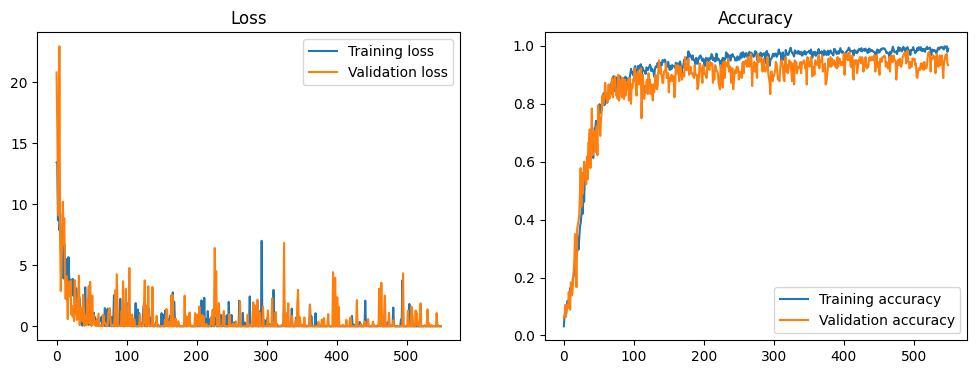

Epoch [551/1100], Loss: 0.0, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 0.000250500000000002 -> 0.00025004636363636567
Validation Accuracy: 0.9222222222222223 Validation loss: 7.480275598936714e-06 Correct: 166 Total: 180
Epoch [552/1100], Loss: 1.5039581739983987e-05, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 0.00025004636363636567 -> 0.0002495927272727293
Validation Accuracy: 0.95 Validation loss: 1.567553226777818e-05 Correct: 171 Total: 180
Epoch [553/1100], Loss: 0.0, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 0.0002495927272727293 -> 0.00024913909090909297
Validation Accuracy: 0.9333333333333333 Validation loss: 3.5762598145083757e-06 Correct: 168 Total: 180
Epoch [554/1100], Loss: 4.2791187297552824e-05, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 0.00024913909090909297 -> 0.00024868545454545657
Validation Accuracy: 0.9333333333333333 Validation loss: 2.4362173080444336 Correct: 168 Total: 180
Epoch [555/1100], Loss: 0.0001

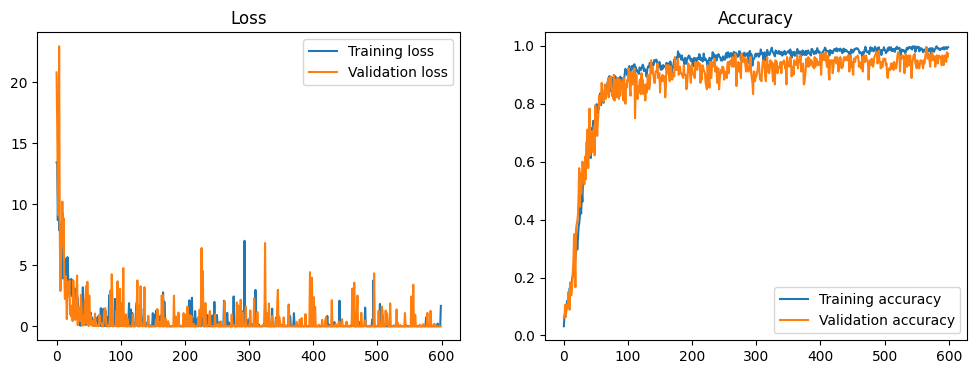

Epoch [601/1100], Loss: 4.371005388748017e-07, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 0.00022781818181818385 -> 0.00022736454545454747
Validation Accuracy: 0.9611111111111111 Validation loss: 0.16382044553756714 Correct: 173 Total: 180
Epoch [602/1100], Loss: 1.4602497685700655e-05, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 0.00022736454545454747 -> 0.0002269109090909111
Validation Accuracy: 0.9277777777777778 Validation loss: 9.97905881376937e-05 Correct: 167 Total: 180
Epoch [603/1100], Loss: 1.9868213740892315e-08, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 0.0002269109090909111 -> 0.00022645727272727471
Validation Accuracy: 0.9555555555555556 Validation loss: 0.08184482902288437 Correct: 172 Total: 180
Epoch [604/1100], Loss: 6.099451184127247e-06, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 0.00022645727272727471 -> 0.00022600363636363834
Validation Accuracy: 0.9388888888888889 Validation loss: 1.0251788808091078e-05 Corr

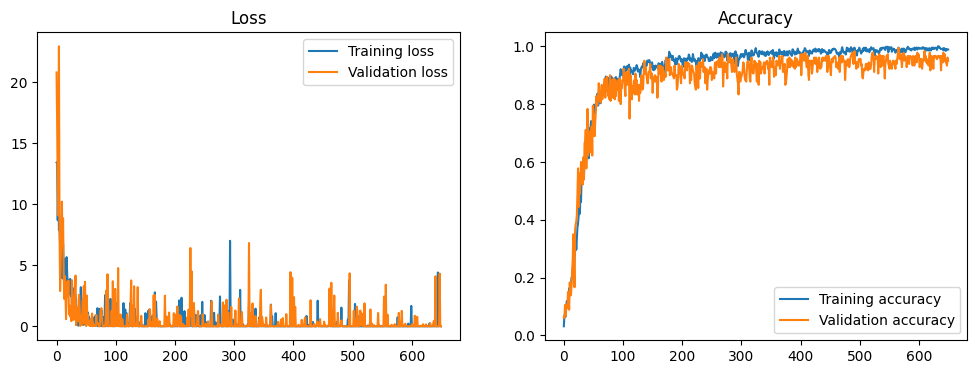

Epoch [651/1100], Loss: 2.4636440230096923e-06, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 0.0002051363636363653 -> 0.0002046827272727289
Validation Accuracy: 0.9666666666666667 Validation loss: 2.2947699562791968e-06 Correct: 174 Total: 180
Epoch [652/1100], Loss: 6.099431175243808e-06, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 0.0002046827272727289 -> 0.00020422909090909256
Validation Accuracy: 0.9444444444444444 Validation loss: 0.00014560155977960676 Correct: 170 Total: 180
Epoch [653/1100], Loss: 2.533004771976266e-05, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 0.00020422909090909256 -> 0.0002037754545454562
Validation Accuracy: 0.9222222222222223 Validation loss: 0.0008822683012112975 Correct: 166 Total: 180
Epoch [654/1100], Loss: 0.003716547740623355, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 0.0002037754545454562 -> 0.00020332181818181986
Validation Accuracy: 0.9611111111111111 Validation loss: 1.3529887837648857e-05 Co

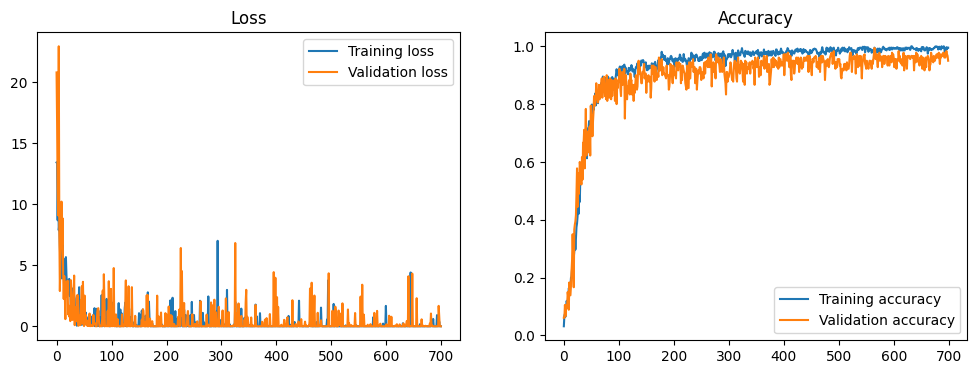

Epoch [701/1100], Loss: 0.0029262935277074575, Accuracy: 0.9873015873015873 Correct: 622 Total: 630 LR: 0.000182454545454547 -> 0.00018200090909091066
Validation Accuracy: 0.9555555555555556 Validation loss: 0.0 Correct: 172 Total: 180
Epoch [702/1100], Loss: 3.0199414595699636e-06, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 0.00018200090909091066 -> 0.0001815472727272743
Validation Accuracy: 0.95 Validation loss: 8.94068591605901e-07 Correct: 171 Total: 180
Epoch [703/1100], Loss: 8.02657177700894e-06, Accuracy: 0.9793650793650793 Correct: 617 Total: 630 LR: 0.0001815472727272743 -> 0.00018109363636363793
Validation Accuracy: 0.9555555555555556 Validation loss: 0.001190507784485817 Correct: 172 Total: 180
Epoch [704/1100], Loss: 4.7499863285338506e-05, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 0.00018109363636363793 -> 0.00018064000000000155
Validation Accuracy: 0.9388888888888889 Validation loss: 6.36198601569049e-05 Correct: 169 Total: 180
Epoch [705/110

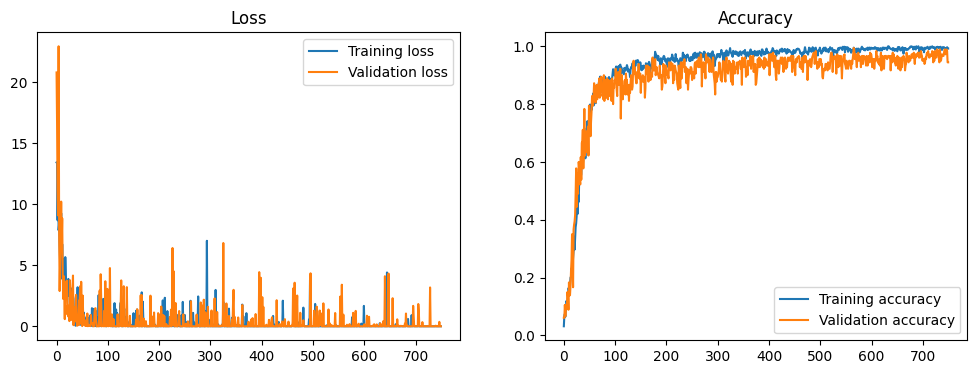

Epoch [751/1100], Loss: 7.94728478581419e-08, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 0.0001597727272727286 -> 0.00015931909090909224
Validation Accuracy: 0.9722222222222222 Validation loss: 0.002131122862920165 Correct: 175 Total: 180
Epoch [752/1100], Loss: 0.004510025028139353, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 0.00015931909090909224 -> 0.00015886545454545589
Validation Accuracy: 0.9666666666666667 Validation loss: 0.00011995556997135282 Correct: 174 Total: 180
Epoch [753/1100], Loss: 1.2318276958467322e-06, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 0.00015886545454545589 -> 0.0001584118181818195
Validation Accuracy: 0.9444444444444444 Validation loss: 0.9270464181900024 Correct: 170 Total: 180
Epoch [754/1100], Loss: 0.0, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 0.0001584118181818195 -> 0.00015795818181818313
Validation Accuracy: 0.9666666666666667 Validation loss: 0.0016367039643228054 Correct: 174 Total: 180
E

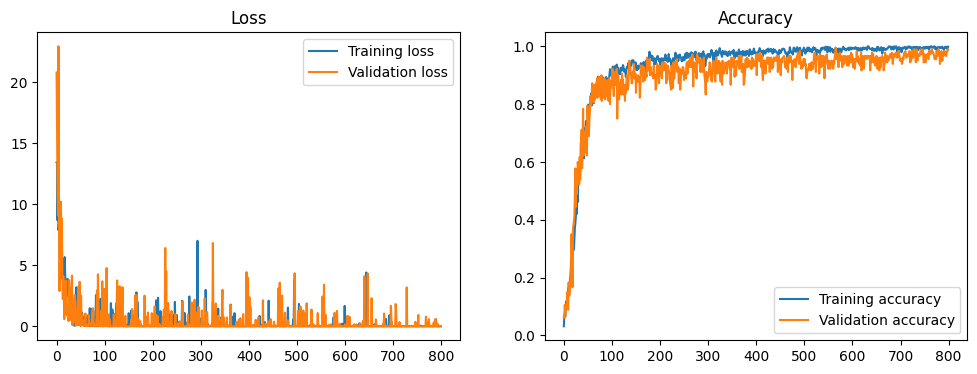

Epoch [801/1100], Loss: 0.0, Accuracy: 1.0 Correct: 630 Total: 630 LR: 0.00013709090909091036 -> 0.000136637272727274
Validation Accuracy: 0.9944444444444445 Validation loss: 0.0 Correct: 179 Total: 180
Epoch [802/1100], Loss: 2.582865761269204e-07, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 0.000136637272727274 -> 0.00013618363636363765
Validation Accuracy: 0.9888888888888889 Validation loss: 0.00028887519147247076 Correct: 178 Total: 180
Epoch [803/1100], Loss: 3.973642392907095e-08, Accuracy: 1.0 Correct: 630 Total: 630 LR: 0.00013618363636363765 -> 0.00013573000000000128
Validation Accuracy: 0.9777777777777777 Validation loss: 0.00036419896059669554 Correct: 176 Total: 180
Epoch [804/1100], Loss: 3.576275275918306e-07, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 0.00013573000000000128 -> 0.0001352763636363649
Validation Accuracy: 0.9833333333333333 Validation loss: 0.02102281153202057 Correct: 177 Total: 180
Epoch [805/1100], Loss: 0.4789523780345917, Acc

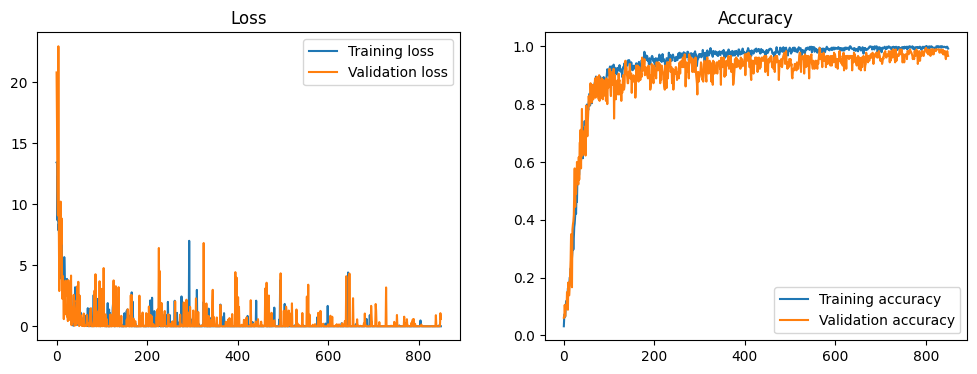

Epoch [851/1100], Loss: 2.006682507271762e-06, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 0.00011440909090909198 -> 0.00011395545454545561
Validation Accuracy: 0.9722222222222222 Validation loss: 0.000475520413601771 Correct: 175 Total: 180
Epoch [852/1100], Loss: 4.907386482955189e-06, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 0.00011395545454545561 -> 0.00011350181818181925
Validation Accuracy: 0.9722222222222222 Validation loss: 0.0005197185673750937 Correct: 175 Total: 180
Epoch [853/1100], Loss: 8.686164073878899e-05, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 0.00011350181818181925 -> 0.00011304818181818287
Validation Accuracy: 0.9833333333333333 Validation loss: 0.0 Correct: 177 Total: 180
Epoch [854/1100], Loss: 1.7285265130340122e-06, Accuracy: 1.0 Correct: 630 Total: 630 LR: 0.00011304818181818287 -> 0.0001125945454545465
Validation Accuracy: 0.9888888888888889 Validation loss: 0.1562109887599945 Correct: 178 Total: 180
Epoch [855/11

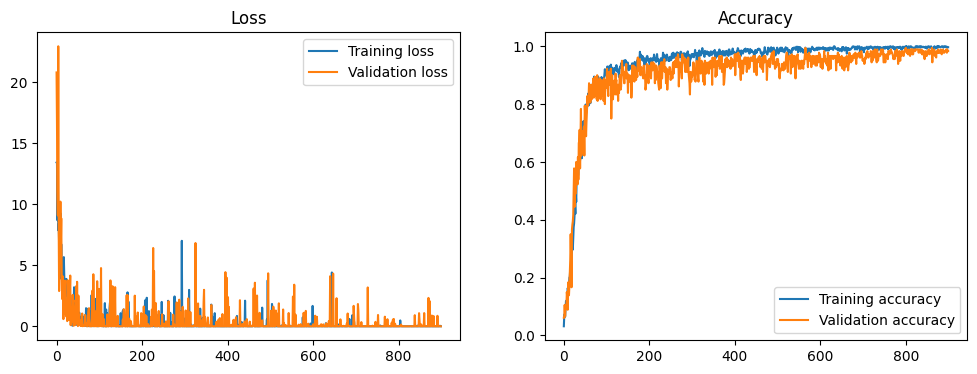

Epoch [901/1100], Loss: 3.409060082049109e-05, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 9.172727272727361e-05 -> 9.127363636363725e-05
Validation Accuracy: 0.9833333333333333 Validation loss: 0.5423341989517212 Correct: 177 Total: 180
Epoch [902/1100], Loss: 1.0331452813261421e-06, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 9.127363636363725e-05 -> 9.082000000000088e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 1.1920926112907182e-07 Correct: 175 Total: 180
Epoch [903/1100], Loss: 7.94728478581419e-08, Accuracy: 1.0 Correct: 630 Total: 630 LR: 9.082000000000088e-05 -> 9.036636363636452e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.2549040615558624 Correct: 174 Total: 180
Epoch [904/1100], Loss: 2.3841850804728892e-07, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 9.036636363636452e-05 -> 8.991272727272815e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 8.030435856198892e-05 Correct: 174 Total: 180
Epo

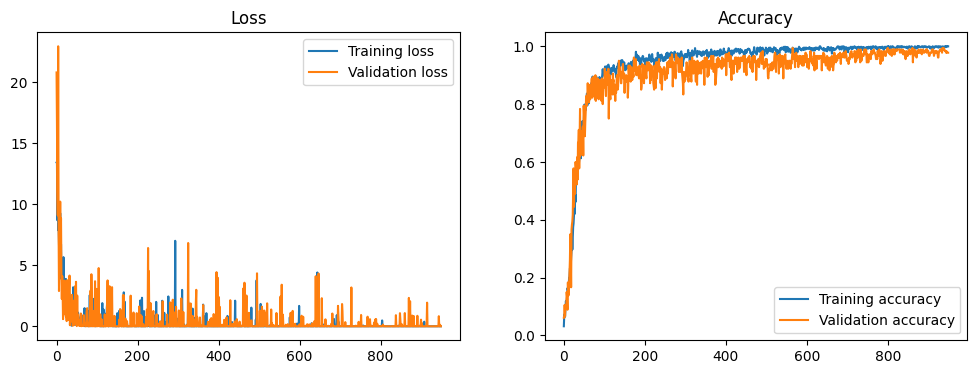

Epoch [951/1100], Loss: 1.9868213740892315e-08, Accuracy: 1.0 Correct: 630 Total: 630 LR: 6.904545454545533e-05 -> 6.859181818181895e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 2.562986537668621e-06 Correct: 176 Total: 180
Epoch [952/1100], Loss: 0.0001356857392238453, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 6.859181818181895e-05 -> 6.813818181818258e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 8.910737051337492e-06 Correct: 176 Total: 180
Epoch [953/1100], Loss: 1.0530123972785077e-06, Accuracy: 1.0 Correct: 630 Total: 630 LR: 6.813818181818258e-05 -> 6.768454545454622e-05
Validation Accuracy: 0.9833333333333333 Validation loss: 0.0039479611441493034 Correct: 177 Total: 180
Epoch [954/1100], Loss: 0.0, Accuracy: 1.0 Correct: 630 Total: 630 LR: 6.768454545454622e-05 -> 6.723090909090986e-05
Validation Accuracy: 0.9888888888888889 Validation loss: 2.3841852225814364e-07 Correct: 178 Total: 180
Epoch [955/1100], Loss: 3.5762749917012115e-

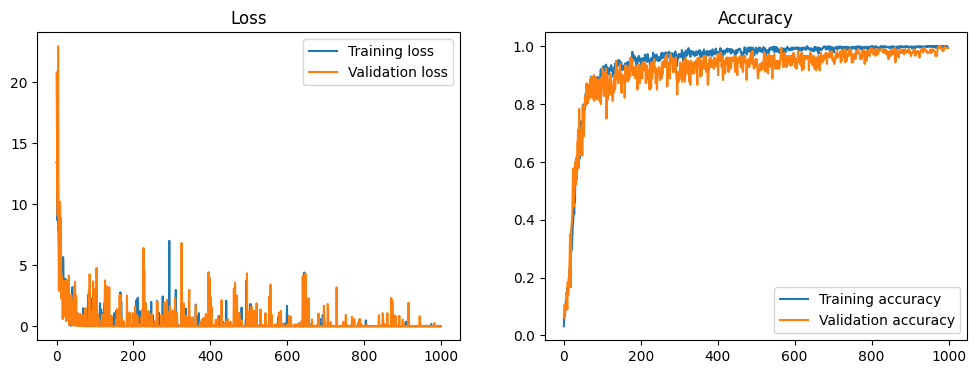

Epoch [1001/1100], Loss: 0.0, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 4.6363636363636885e-05 -> 4.591000000000052e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 8.046613970691396e-07 Correct: 179 Total: 180
Epoch [1002/1100], Loss: 2.153580317099113e-05, Accuracy: 1.0 Correct: 630 Total: 630 LR: 4.591000000000052e-05 -> 4.545636363636415e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.0006129674729891121 Correct: 179 Total: 180
Epoch [1003/1100], Loss: 0.0009954452980309725, Accuracy: 1.0 Correct: 630 Total: 630 LR: 4.545636363636415e-05 -> 4.500272727272778e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.8956699371337891 Correct: 179 Total: 180
Epoch [1004/1100], Loss: 3.178913061674393e-07, Accuracy: 1.0 Correct: 630 Total: 630 LR: 4.500272727272778e-05 -> 4.4549090909091415e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 2.3841846541472478e-07 Correct: 179 Total: 180
Epoch [1005/1100], Loss: 2.9802296808156825

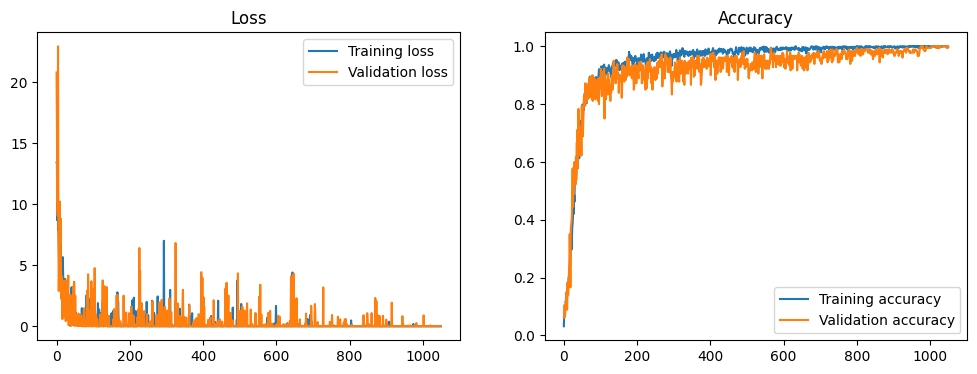

Epoch [1051/1100], Loss: 4.291009099688381e-05, Accuracy: 1.0 Correct: 630 Total: 630 LR: 2.3681818181818428e-05 -> 2.322818181818206e-05
Validation Accuracy: 1.0 Validation loss: 0.011977974325418472 Correct: 180 Total: 180
Epoch [1052/1100], Loss: 2.046413555945037e-06, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 2.322818181818206e-05 -> 2.2774545454545693e-05
Validation Accuracy: 1.0 Validation loss: 2.771600520645734e-06 Correct: 180 Total: 180
Epoch [1053/1100], Loss: 0.0006716013886034489, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 2.2774545454545693e-05 -> 2.2320909090909325e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 5.960463766996327e-08 Correct: 179 Total: 180
Epoch [1054/1100], Loss: 3.9736383428135014e-07, Accuracy: 1.0 Correct: 630 Total: 630 LR: 2.2320909090909325e-05 -> 2.1867272727272958e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 1.221892262037727e-06 Correct: 179 Total: 180
Epoch [1055/1100], Loss: 3.9736400

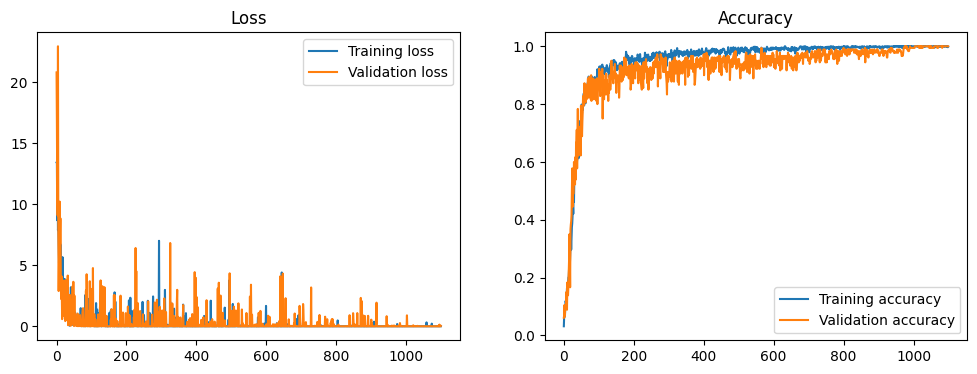

In [27]:
best_model_path = "CoAtNet-1-Best-Zoom.pkl"
model_path = "CoAtNet-1-Zoom.pkl"

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

In [28]:
save_model(model, model_path)

### Results

In [29]:
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

MyCoAtNet(
  (0): Sequential(
    (0): Stem(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (1): Sequential(
    (0): DownsamplingMBConv(
      (mb_conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): GELU(approximate='none')
        (7): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
    

In [30]:
print("Best validation acc: ", max(val_accuracies))
print("Last validation acc: ", val_accuracies[-1])

Best validation acc:  1.0
Last validation acc:  1.0


In [31]:
# Generate the alphabet (0-9 and A-Z)
digits = [str(digit) for digit in range(10)]
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]

# Combine digits and alphabet
all_characters = digits + alphabet

# Create the label dictionary
label_dict = {i: all_characters[i] for i in range(len(all_characters))}

# Print the label dictionary
print(label_dict)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [32]:
# Adapted from My_CoAtNet
predictions_path = 'predictions-zoom.csv'

def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:

        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

### Test accuracy

In [33]:
cm = predict(test_dataloader)

Test Accuracy: 0.9777777777777777


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
predicted_labels,L,N,X,Z,L,J,F,7,Q,1,F,E,E,V,X,A,H,J,K,Y,P,C,R,8,X,5,N,9,G,W,M,R,F,O,V,1,3,X,J,O,Q,9,Q,O,A,4,S,L,3,R,C,J,X,3,J,Y,L,7,8,N,T,T,9,N,N,Z,X,F,Y,9,2,2,I,G,I,J,5,A,1,K,8,B,2,P,E,1,J,3,W,O
true_labels,L,N,X,Z,L,J,F,7,Q,1,F,E,E,V,X,A,H,J,K,Y,P,C,R,8,X,5,N,9,G,W,M,R,F,O,V,1,3,X,J,O,Q,9,Q,O,A,4,S,L,3,R,X,J,X,3,J,Y,L,7,8,N,T,T,9,N,N,Z,X,F,Y,9,2,Q,I,G,I,J,5,A,1,K,8,B,2,P,E,1,J,3,W,O


0.9777777777777777
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         1
          12       0.50      1.00      0.67         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         2
          19       1.00      1.00      1.00         7
        

### Confusion matrix

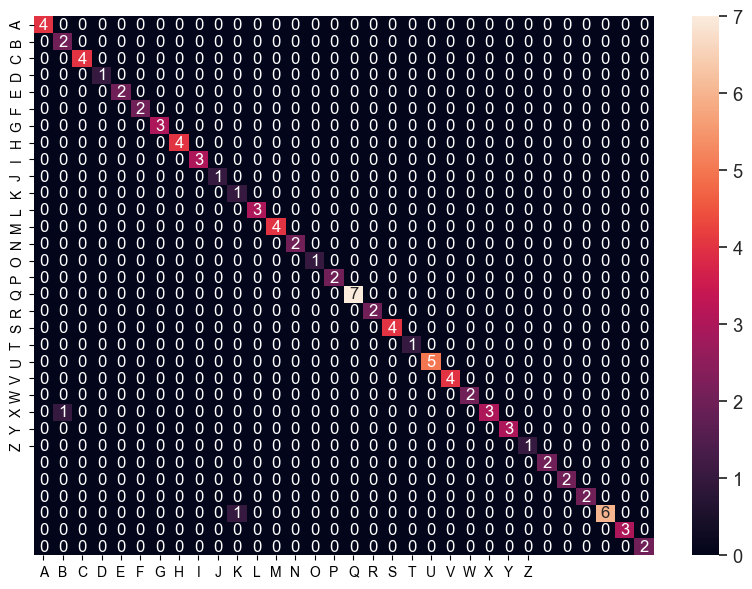

In [34]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=alphabet, 
                yticklabels=alphabet,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1")